# Sklearn

## Bike Sharing Demand
Задача на kaggle: https://www.kaggle.com/c/bike-sharing-demand

По историческим данным о прокате велосипедов и погодным условиям необходимо оценить спрос на прокат велосипедов.

В исходной постановке задачи доступно 11 признаков: https://www.kaggle.com/c/prudential-life-insurance-assessment/data

В наборе признаков присутсвуют вещественные, категориальные, и бинарные данные. 

Для демонстрации используется обучающая выборка из исходных данных train.csv, файлы для работы прилагаются.

### Библиотеки

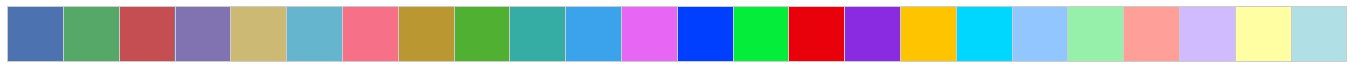

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as sts
import seaborn as sns

sns.set()
sns.set_style("whitegrid")

color_palette = sns.color_palette('deep') + sns.color_palette('husl', 6) + sns.color_palette('bright') + sns.color_palette('pastel')

%matplotlib inline
sns.palplot(color_palette)

In [2]:
from sklearn import datasets, linear_model, metrics, model_selection as mdsel

### Загрузка данных

In [34]:
raw_data = pd.read_csv('data/13_14_bike_sharing_demand_train.csv', header = 0, sep = ',')

In [35]:
raw_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


***datetime*** - hourly date + timestamp  

***season*** -  1 = spring, 2 = summer, 3 = fall, 4 = winter 

***holiday*** - whether the day is considered a holiday

***workingday*** - whether the day is neither a weekend nor holiday

***weather*** - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
    
***temp*** - temperature in Celsius

***atemp*** - "feels like" temperature in Celsius

***humidity*** - relative humidity

***windspeed*** - wind speed

***casual*** - number of non-registered user rentals initiated

***registered*** - number of registered user rentals initiated

***count*** - number of total rentals

In [36]:
raw_data.shape

(10886, 12)

In [37]:
raw_data.isnull().values.any()

False

### Предобработка данных

#### Типы признаков

In [38]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB


In [39]:
raw_data.datetime = raw_data.datetime.apply(pd.to_datetime)

In [40]:
raw_data['week'] = raw_data.datetime.dt.week
raw_data['hour'] = raw_data.datetime.dt.hour

In [41]:
raw_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,week,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,52,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,52,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,52,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,52,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,52,4


#### Обучение и отложенный тест

In [42]:
train_data = raw_data.iloc[:-1000, :]
hold_out_test_data = raw_data.iloc[-1000:, :]

In [43]:
raw_data.shape, train_data.shape, hold_out_test_data.shape

((10886, 14), (9886, 14), (1000, 14))

In [44]:
print('train period from {} to {}'.format(train_data.datetime.min(), train_data.datetime.max()))
print('evaluation period from {} to {}'.format(hold_out_test_data.datetime.min(), hold_out_test_data.datetime.max()))

train period from 2011-01-01 00:00:00 to 2012-10-16 06:00:00
evaluation period from 2012-10-16 07:00:00 to 2012-12-19 23:00:00


#### Данные и целевая функция

In [45]:
#обучение
train_labels = train_data['count'].values
train_data = train_data.drop(['datetime', 'count'], axis = 1)

In [46]:
#тест
test_labels = hold_out_test_data['count'].values
test_data = hold_out_test_data.drop(['datetime', 'count'], axis = 1)

#### Целевая функция на обучающей выборке и на отложенном тесте

Text(0.5,1,'test data')

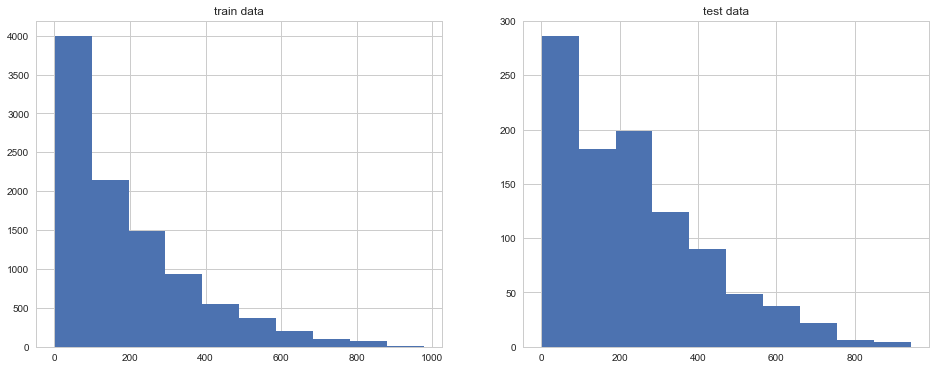

In [47]:
plt.figure(figsize = (16, 6))

plt.subplot(1,2,1)
plt.hist(train_labels)
plt.title('train data')

plt.subplot(1,2,2)
plt.hist(test_labels)
plt.title('test data')

#### Числовые признаки

In [50]:
numeric_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'week', 'hour']

In [51]:
train_data = train_data[numeric_columns]
test_data = test_data[numeric_columns]

In [52]:
train_data.head()

,temp,atemp,humidity,windspeed,casual,registered,week,hour
0,9.84,14.395,81,0.0,3,13,52,0
1,9.02,13.635,80,0.0,8,32,52,1
2,9.02,13.635,80,0.0,5,27,52,2
3,9.84,14.395,75,0.0,3,10,52,3
4,9.84,14.395,75,0.0,0,1,52,4


In [53]:
test_data.head()

,temp,atemp,humidity,windspeed,casual,registered,week,hour
9886,17.22,21.210,67,6.0032,20,505,42,7
9887,18.04,21.970,62,0.0000,35,800,42,8
9888,19.68,23.485,55,16.9979,32,323,42,9
9889,20.50,24.240,48,19.0012,65,157,42,10
9890,20.50,24.240,45,27.9993,56,172,42,11


### Модель

In [60]:
regressor = linear_model.SGDRegressor(random_state = 0, tol=1e-3)

In [61]:
regressor.fit(train_data, train_labels)
metrics.mean_absolute_error(test_labels, regressor.predict(test_data))

11186184737981.078

In [64]:
print(test_labels[:10])

[525 835 355 222 228 325 328 308 346 446]


In [65]:
print(regressor.predict(test_data)[:10])

[-3.96429460e+13 -6.79176796e+13 -1.73084555e+13  7.88985531e+12
  4.77334183e+12 -1.46078540e+12 -2.30713797e+12  8.29511621e+12
 -1.35971540e+12 -1.11695026e+13]


In [67]:
print(regressor.coef_)

[-9.87639774e+10  5.96060380e+10  4.81033491e+10  7.80527340e+10
  2.37651392e+11 -1.05568102e+11  1.25129679e+11  4.78543183e+10]


### Scaling

In [68]:
from sklearn.preprocessing import StandardScaler

In [69]:
#создаем стандартный scaler
scaler = StandardScaler()
scaler.fit(train_data, train_labels)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [70]:
regressor.fit(scaled_train_data, train_labels)
metrics.mean_absolute_error(test_labels, regressor.predict(scaled_test_data))

0.05436469568679682

In [71]:
print(test_labels[:10])

[525 835 355 222 228 325 328 308 346 446]


In [72]:
print(regressor.predict(scaled_test_data)[:10])

[524.89374391 834.87753509 354.92288695 221.95365443 227.92782548
 324.94348586 327.9524775  307.97599296 345.95543578 445.95046959]


### Подозрительно хорошо?

In [74]:
print(regressor.coef_)

[ 6.17425696e-01 -6.10758420e-01  2.68249918e-03 -2.23962548e-02
  5.08596793e+01  1.48006526e+02 -1.39507350e-03  1.00362403e-02]


In [78]:
print(list(map(lambda x : round(x, 3), regressor.coef_)))

[0.617, -0.611, 0.003, -0.022, 50.86, 148.007, -0.001, 0.01]


In [79]:
train_data.head()

,temp,atemp,humidity,windspeed,casual,registered,week,hour
0,9.84,14.395,81,0.0,3,13,52,0
1,9.02,13.635,80,0.0,8,32,52,1
2,9.02,13.635,80,0.0,5,27,52,2
3,9.84,14.395,75,0.0,3,10,52,3
4,9.84,14.395,75,0.0,0,1,52,4


In [80]:
train_labels[:10]

array([16, 40, 32, 13,  1,  1,  2,  3,  8, 14], dtype=int64)

In [81]:
np.all(train_data.registered + train_data.casual == train_labels)

True

In [82]:
train_data.drop(['casual', 'registered'], axis = 1, inplace = True)
test_data.drop(['casual', 'registered'], axis = 1, inplace = True)

In [83]:
scaler.fit(train_data, train_labels)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [84]:
regressor.fit(scaled_train_data, train_labels)
metrics.mean_absolute_error(test_labels, regressor.predict(scaled_test_data))

123.23749890398362

In [85]:
print(list(map(lambda x : round(x, 3), regressor.coef_)))

[32.535, 30.574, -43.708, 1.009, 7.156, 50.434]


### Pipeline

In [86]:
from sklearn.pipeline import Pipeline

In [87]:
#создаем pipeline из двух шагов: scaling и классификация
pipeline = Pipeline(steps = [('scaling', scaler), ('regression', regressor)])

In [88]:
pipeline.fit(train_data, train_labels)
metrics.mean_absolute_error(test_labels, pipeline.predict(test_data))

123.23749890398362

### Подбор параметров

In [89]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'scaling', 'regression', 'scaling__copy', 'scaling__with_mean', 'scaling__with_std', 'regression__alpha', 'regression__average', 'regression__epsilon', 'regression__eta0', 'regression__fit_intercept', 'regression__l1_ratio', 'regression__learning_rate', 'regression__loss', 'regression__max_iter', 'regression__n_iter', 'regression__penalty', 'regression__power_t', 'regression__random_state', 'regression__shuffle', 'regression__tol', 'regression__verbose', 'regression__warm_start'])

In [94]:
parameters_grid = {
    'regression__loss' : ['huber', 'epsilon_insensitive', 'squared_loss', ],
    'regression__max_iter' : [3, 5, 10, 50], 
    'regression__penalty' : ['l1', 'l2', 'none'],
    'regression__alpha' : [0.0001, 0.01],
    'scaling__with_mean' : [0., 0.5],
}

In [97]:
grid_cv = mdsel.GridSearchCV(pipeline, parameters_grid, scoring = 'neg_mean_absolute_error', cv = 4)

In [100]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=Warning)

In [101]:
%%time
grid_cv.fit(train_data, train_labels)

Wall time: 11.8 s


GridSearchCV(cv=4, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaling', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regression', SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=None, penalty='l2',
       power_t=0.25, random_state=0, shuffle=True, tol=0.001, verbose=0,
       warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'regression__loss': ['huber', 'epsilon_insensitive', 'squared_loss'], 'regression__max_iter': [3, 5, 10, 50], 'regression__penalty': ['l1', 'l2', 'none'], 'regression__alpha': [0.0001, 0.01], 'scaling__with_mean': [0.0, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [102]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

-108.22301246612612
{'regression__alpha': 0.01, 'regression__loss': 'squared_loss', 'regression__max_iter': 3, 'regression__penalty': 'l2', 'scaling__with_mean': 0.0}


### Оценка по отложенному тесту

In [103]:
metrics.mean_absolute_error(test_labels, grid_cv.best_estimator_.predict(test_data))

120.49374338846968

In [104]:
np.mean(test_labels)

232.159

In [105]:
test_predictions = grid_cv.best_estimator_.predict(test_data)

In [106]:
print(test_labels[:10])

[525 835 355 222 228 325 328 308 346 446]


In [107]:
print(test_predictions[:10])

[137.94285971 158.27708378 205.79735829 235.93650495 255.78878348
 265.63803817 270.75754365 296.00269207 302.55701311 311.8723911 ]


(-100, 1100)

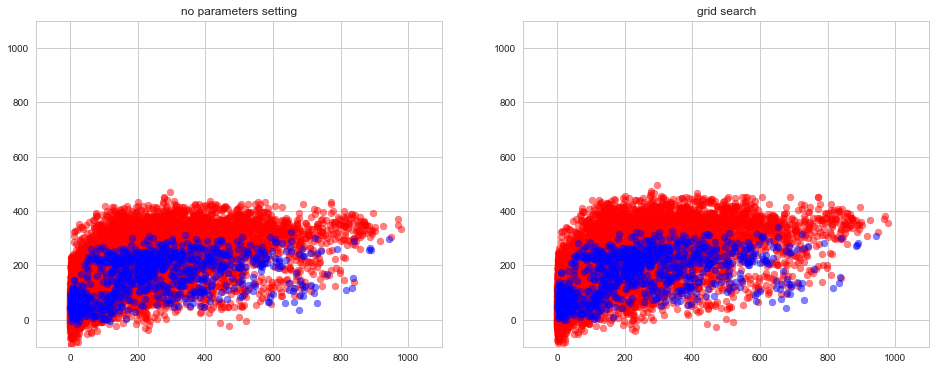

In [108]:
plt.figure(figsize=(16, 6))

plt.subplot(1,2,1)
plt.grid(True)
plt.scatter(train_labels, pipeline.predict(train_data), alpha=0.5, color = 'red')
plt.scatter(test_labels, pipeline.predict(test_data), alpha=0.5, color = 'blue')
plt.title('no parameters setting')
plt.xlim(-100,1100)
plt.ylim(-100,1100)

plt.subplot(1,2,2)
plt.grid(True)
plt.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color = 'red')
plt.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color = 'blue')
plt.title('grid search')
plt.xlim(-100,1100)
plt.ylim(-100,1100)